In [158]:
import sys, os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.neighbors import NearestNeighbors

In [159]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, classification_report
from scipy.sparse import hstack
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

In [160]:
!pip install -q stanza

In [161]:
!pip install -q lightgbm
import lightgbm as lgb

In [162]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.decomposition import TruncatedSVD
import stanza
from sklearn.decomposition import PCA

In [163]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
stanza.download('en', processors='lemma')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


INFO:stanza:Downloaded file to /root/stanza_resources/resources.json
INFO:stanza:Downloading these customized packages for language: en (English)...
| Processor | Package           |
---------------------------------
| lemma     | combined_nocharlm |

INFO:stanza:File exists: /root/stanza_resources/en/lemma/combined_nocharlm.pt
INFO:stanza:Finished downloading models and saved to /root/stanza_resources


In [164]:
!pip install -q sentence_transformers
from sentence_transformers import SentenceTransformer

In [165]:
if 'google.colab' in sys.modules:
    # mount google drive
    from google.colab import drive
    drive.mount('/content/gdrive')
    path_to_file = '/content/gdrive/MyDrive/BT5153_2024/Group Proj'
    print(path_to_file)
    os.chdir(path_to_file)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/MyDrive/BT5153_2024/Group Proj


In [166]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [167]:
import pandas as pd

# Initialize an empty DataFrame for logging model performances
model_performance_log = pd.DataFrame(columns=['model', 'accuracy', 'recall', 'precision', 'f1_score'])

In [168]:
data  = pd.read_csv('mix_combined.csv')

### Model 1a: TFIDF for combined text + RF model (without numerical features)

In [169]:
def preprocess_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'http\S+|@\S+|#\S+', '', text)  # Remove URLs, mentions, and hashtags
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove punctuation
    tokens = nltk.word_tokenize(text)  # Tokenize
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word not in stop_words]  # Remove stopwords
    doc = nlp(' '.join(filtered_tokens))
    lemmatized_tokens = [word.lemma for sent in doc.sentences for word in sent.words]
    return ' '.join(lemmatized_tokens)
nlp = stanza.Pipeline('en', processors='tokenize,lemma')

INFO:stanza:Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


INFO:stanza:Downloaded file to /root/stanza_resources/resources.json
INFO:stanza:Loading these models for language: en (English):
| Processor | Package           |
---------------------------------
| tokenize  | combined          |
| mwt       | combined          |
| lemma     | combined_nocharlm |

INFO:stanza:Using device: cuda
INFO:stanza:Loading: tokenize
INFO:stanza:Loading: mwt
INFO:stanza:Loading: lemma
INFO:stanza:Done loading processors!


In [170]:
data['combined_text'] = data['combined_text'].apply(preprocess_text)

In [171]:
# Count Vectorization
vectorizer = CountVectorizer(max_features=300, ngram_range=(1, 2))
count_matrix = vectorizer.fit_transform(data['combined_text'])

# TF-IDF Transformation
tfidf_transformer = TfidfTransformer()
tfidf_matrix = tfidf_transformer.fit_transform(count_matrix)
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())

# Combine the original DataFrame with the TF-IDF features
whole_tfidf_df = pd.concat([data, tfidf_df], axis=1)

# Print the new DataFrame structure
print('The number of columns in data is:', data.shape[1],
      'The number of columns in tfidf_df is:', tfidf_df.shape[1],
      'The number of columns in whole_tfidf_df is:', whole_tfidf_df.shape[1])

The number of columns in data is: 118 The number of columns in tfidf_df is: 300 The number of columns in whole_tfidf_df is: 418


In [172]:
# Columns to drop, ensure they exist in the DataFrame to avoid KeyError
columns_to_drop = ['combined_text', 'preprocessed_combined_text', 'languages', 'summary', 'education', 'experiences', 'user_id', 'num of languages', 'num of education','num of experiences'] + \
                  [col for col in data.columns if 'skill_k50_' in col] + [col for col in data.columns if 'language_' in col]
columns_to_drop = [col for col in columns_to_drop if col in whole_tfidf_df.columns]

# Drop specified columns safely
tfidf_df_x = whole_tfidf_df.drop(columns=columns_to_drop)

# Target variables - ensure to filter only existing skill columns
skill_columns = [col for col in data.columns if 'skill_k50_' in col and col in whole_tfidf_df.columns]
tfidf_df_y = whole_tfidf_df[skill_columns]

In [173]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(tfidf_df_x, tfidf_df_y, test_size=0.3, random_state=42)

In [174]:
# Compute class weights for each label and then average them for each sample
sample_weights_list = [compute_sample_weight(class_weight='balanced', y=y_train[col]) for col in y_train.columns]
sample_weights = np.vstack(sample_weights_list).T.mean(axis=1)

In [175]:
# Model: Using RandomForest
classifier = RandomForestClassifier(n_estimators=100, random_state=42)
multi_target_classifier_model_a = MultiOutputClassifier(classifier, n_jobs=-1)

In [176]:
# Train the model
multi_target_classifier_model_a.fit(X_train, y_train, sample_weight=sample_weights)
# Predict on test data
y_pred = multi_target_classifier_model_a.predict(X_test)

In [177]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, average='samples')
precision = precision_score(y_test, y_pred, average='samples')
f1 = f1_score(y_test, y_pred, average='samples')

print(f'Accuracy: {accuracy}')
print(f'Recall: {recall}')
print(f'Precision: {precision}')
print(f'F1 Score: {f1}')

Accuracy: 0.18387413962635202
Recall: 0.4844310654355678
Precision: 0.8693543100622747
F1 Score: 0.5627368857742748


In [178]:
print(classification_report(y_test, y_pred, target_names=tfidf_df_y.columns))

                                                                                       precision    recall  f1-score   support

                                skill_k50_accounting / financial reporting / auditing       1.00      0.03      0.06       128
                                    skill_k50_analysis / financial analysis / finance       0.91      1.00      0.95       922
                              skill_k50_autocad / solidworks / mechanical engineering       0.00      0.00      0.00        15
                                               skill_k50_banking / insurance / credit       1.00      0.13      0.23       158
                                  skill_k50_biotechnology / life sciences / chemistry       0.93      0.22      0.36        59
                        skill_k50_business analysis / change management / integration       0.60      0.02      0.04       137
             skill_k50_coaching / leadership development / organizational development       0.00      0.00    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [179]:
def log_model_performance(model_performance_log, model_name, y_test, y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred, average='samples')
    precision = precision_score(y_test, y_pred, average='samples')
    f1 = f1_score(y_test, y_pred, average='samples')
    new_row = pd.DataFrame({
        'model': [model_name],
        'accuracy': [accuracy],
        'recall': [recall],
        'precision': [precision],
        'f1_score': [f1]
    })

    return pd.concat([model_performance_log, new_row], ignore_index=True)

model_performance_log = log_model_performance(model_performance_log, 'combined_text only', y_test, y_pred)

### Model 1b: TFIDF for combined text + RF model (with numerical features)

In [180]:
# Numerical features
numerical_features = data.select_dtypes(include=['int64', 'float64']).drop(['user_id'] + [col for col in data.columns if col.startswith('skill_k50_')] + [col for col in data.columns if col.startswith('language_')], axis=1)

In [181]:
# Include numerical features
combined_features = pd.concat([tfidf_df_x, numerical_features.reset_index(drop=True)], axis=1)

In [182]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(combined_features, tfidf_df_y, test_size=0.3, random_state=42)

In [183]:
# Model: Using RandomForest
classifier = RandomForestClassifier(n_estimators=100, random_state=42)
multi_target_classifier_model_b = MultiOutputClassifier(classifier, n_jobs=-1)

In [184]:
# Train the model
multi_target_classifier_model_b.fit(X_train, y_train, sample_weight=sample_weights)
# Predict on test data
y_pred = multi_target_classifier_model_b.predict(X_test)

In [185]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, average='samples')
precision = precision_score(y_test, y_pred, average='samples')
f1 = f1_score(y_test, y_pred, average='samples')

print(f'Accuracy: {accuracy}')
print(f'Recall: {recall}')
print(f'Precision: {precision}')
print(f'F1 Score: {f1}')

Accuracy: 0.1887905604719764
Recall: 0.4902755582638365
Precision: 0.8682890855457227
F1 Score: 0.5670759161711861


In [186]:
print(classification_report(y_test, y_pred, target_names=tfidf_df_y.columns))

                                                                                       precision    recall  f1-score   support

                                skill_k50_accounting / financial reporting / auditing       1.00      0.02      0.03       128
                                    skill_k50_analysis / financial analysis / finance       0.91      1.00      0.95       922
                              skill_k50_autocad / solidworks / mechanical engineering       0.00      0.00      0.00        15
                                               skill_k50_banking / insurance / credit       0.83      0.15      0.26       158
                                  skill_k50_biotechnology / life sciences / chemistry       0.89      0.29      0.44        59
                        skill_k50_business analysis / change management / integration       0.67      0.03      0.06       137
             skill_k50_coaching / leadership development / organizational development       0.00      0.00    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [187]:
def log_model_performance(model_performance_log, model_name, y_test, y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred, average='samples')
    precision = precision_score(y_test, y_pred, average='samples')
    f1 = f1_score(y_test, y_pred, average='samples')
    new_row = pd.DataFrame({
        'model': [model_name],
        'accuracy': [accuracy],
        'recall': [recall],
        'precision': [precision],
        'f1_score': [f1]
    })

    return pd.concat([model_performance_log, new_row], ignore_index=True)

model_performance_log = log_model_performance(model_performance_log, 'combined_text with num_features', y_test, y_pred)

### Model 2a: Embedding Experience, Summary and Educ with numerical features + TFIDF combined text

In [188]:
model = SentenceTransformer('all-MiniLM-L6-v2')

# Function to generate embeddings for a given text column
def generate_embeddings(column_name):
    combined_text = data[column_name].fillna("").apply(str)
    embeddings = model.encode(combined_text, convert_to_tensor=True)
    return embeddings.cpu().numpy()

# Generate embeddings
education_embeddings = generate_embeddings('education')
experiences_embeddings = generate_embeddings('experiences')
summary_embeddings = generate_embeddings('summary')

In [189]:
# Combine all features: PCA features, numerical features, and embeddings
features_with_embeddings = np.hstack([
    tfidf_df_x.values,
    numerical_features.values,
    education_embeddings,
    experiences_embeddings,
    summary_embeddings
])

In [190]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_with_embeddings, tfidf_df_y, test_size=0.3, random_state=42)

In [191]:
# RF model
classifier = RandomForestClassifier(n_estimators=100, random_state=42)
multi_target_classifier_embedding = MultiOutputClassifier(classifier, n_jobs=-1)
multi_target_classifier_embedding.fit(X_train, y_train, sample_weight=sample_weights)

MultiOutputClassifier(estimator=RandomForestClassifier(random_state=42),
                      n_jobs=-1)

In [192]:
# Prediction and Evaluation
y_pred = multi_target_classifier_embedding.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Recall: {recall_score(y_test, y_pred, average='samples')}")
print(f"Precision: {precision_score(y_test, y_pred, average='samples')}")
print(f"F1 Score: {f1_score(y_test, y_pred, average='samples')}")

Accuracy: 0.19370698131760078
Recall: 0.4670850589030996
Precision: 0.8769255981645362
F1 Score: 0.5502812371048488


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [193]:
print(classification_report(y_test, y_pred, target_names=tfidf_df_y.columns))

                                                                                       precision    recall  f1-score   support

                                skill_k50_accounting / financial reporting / auditing       0.00      0.00      0.00       128
                                    skill_k50_analysis / financial analysis / finance       0.91      1.00      0.95       922
                              skill_k50_autocad / solidworks / mechanical engineering       0.00      0.00      0.00        15
                                               skill_k50_banking / insurance / credit       0.67      0.01      0.02       158
                                  skill_k50_biotechnology / life sciences / chemistry       0.94      0.29      0.44        59
                        skill_k50_business analysis / change management / integration       1.00      0.01      0.03       137
             skill_k50_coaching / leadership development / organizational development       0.00      0.00    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [194]:
def log_model_performance(model_performance_log, model_name, y_test, y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred, average='samples')
    precision = precision_score(y_test, y_pred, average='samples')
    f1 = f1_score(y_test, y_pred, average='samples')
    new_row = pd.DataFrame({
        'model': [model_name],
        'accuracy': [accuracy],
        'recall': [recall],
        'precision': [precision],
        'f1_score': [f1]
    })

    return pd.concat([model_performance_log, new_row], ignore_index=True)

model_performance_log = log_model_performance(model_performance_log, 'embedded summary + educ + exp + num_features + combined_text', y_test, y_pred)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Model 2b with SMOTE
Using MLSMOTE to upsampling multilabel data https://www.sciencedirect.com/science/article/abs/pii/S0950705115002737 (article) ; https://github.com/niteshsukhwani/MLSMOTE/blob/master/mlsmote.py (sample code)

In [195]:
# Convert X_train and y_train to DataFrame if they are not
if not isinstance(X_train, pd.DataFrame):
    X_train = pd.DataFrame(X_train, columns=[f'feature_{i}' for i in range(X_train.shape[1])])

if not isinstance(y_train, pd.DataFrame):
    y_train = pd.DataFrame(y_train, columns=[f'target_{i}' for i in range(y_train.shape[1])])

In [196]:
# Reset indices to ensure alignment
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

# Define functions for MLSMOTE
def get_tail_label(df, ql=[0.05, 1]):
    """Identify underrepresented targets based on quantile limits."""
    irlbl = df.sum(axis=0)
    irlbl = irlbl[(irlbl > irlbl.quantile(ql[0])) & (irlbl < irlbl.quantile(ql[1]))]
    irlbl = irlbl.max() / irlbl
    threshold_irlbl = irlbl.median()
    tail_label = irlbl[irlbl > threshold_irlbl].index.tolist()
    print(f"Tail labels: {tail_label}")
    return tail_label

def get_minority_samples(X, y, ql=[0.05, 1]):
    """Extract minority samples based on underrepresented targets."""
    tail_labels = get_tail_label(y, ql)
    index = y[y[tail_labels].apply(lambda x: (x == 1).any(), axis=1)].index.tolist()
    print(f"Indices of minority samples: {index}")
    if not index:
        print("No minority samples identified. Adjust quantile limits or check data.")
        return None, None
    X_sub = X.iloc[index].reset_index(drop=True)
    y_sub = y.iloc[index].reset_index(drop=True)
    return X_sub, y_sub

def nearest_neighbour(X, neigh=5):
    """Find nearest neighbours for all instances in the dataset."""
    nbs = NearestNeighbors(n_neighbors=neigh, metric='euclidean').fit(X)
    euclidean, indices = nbs.kneighbors(X)
    return indices

def MLSMOTE(X, y, n_sample, neigh=5):
    """Generate synthetic samples using the MLSMOTE algorithm."""
    indices2 = nearest_neighbour(X, neigh)
    if indices2.size == 0:
        print("No neighbors found. Check the number of minority samples.")
        return pd.DataFrame(), pd.DataFrame()
    new_X = np.zeros((n_sample, X.shape[1]))
    target = np.zeros((n_sample, y.shape[1]))
    for i in range(n_sample):
        reference = random.randint(0, len(indices2) - 1)
        neighbor = random.choice(indices2[reference, 1:])
        all_point = indices2[reference]
        nn_df = y.iloc[all_point]
        ser = nn_df.sum(axis=0, skipna=True)
        target[i] = np.array([1 if val > 1 else 0 for val in ser])
        ratio = np.random.random()
        gap = X.iloc[reference].values - X.iloc[neighbor].values
        new_X[i] = X.iloc[reference].values + ratio * gap
    return pd.DataFrame(new_X, columns=X.columns), pd.DataFrame(target, columns=y.columns)

# Apply MLSMOTE if there are minority samples
X_sub, y_sub = get_minority_samples(X_train, y_train)
if X_sub is not None and y_sub is not None:
    X_synthetic, y_synthetic = MLSMOTE(X_sub, y_sub, 200)
    # Combine the synthetic samples with the original data
    X_train_augmented = pd.concat([X_train, X_synthetic])
    y_train_augmented = pd.concat([y_train, y_synthetic])
else:
    X_train_augmented, y_train_augmented = X_train, y_train

Tail labels: ['skill_k50_autocad / solidworks / mechanical engineering', 'skill_k50_coaching / leadership development / organizational development', 'skill_k50_customer satisfaction / automotive / customer experience', 'skill_k50_engineering / project engineering / gas', 'skill_k50_healthcare / hospitals / healthcare management', 'skill_k50_hospitality / food / hotels', 'skill_k50_html / javascript / css', 'skill_k50_human resources / recruiting / performance management', 'skill_k50_information technology / people management / lean six sigma', 'skill_k50_itil / windows server / it service management', 'skill_k50_java enterprise edition / jira / jsp', 'skill_k50_legal research / legal writing / corporate law', 'skill_k50_mobile devices / mobile applications / ios', 'skill_k50_operations management / inventory management / logistics', 'skill_k50_photoshop / graphic design / adobe creative suite', 'skill_k50_product design / architecture / concept development', 'skill_k50_program manageme

In [197]:
# Recalculate sample weights for the augmented dataset
sample_weights_augmented = np.array([
    compute_sample_weight(class_weight='balanced', y=y_train_augmented[col])
    for col in y_train_augmented.columns
])
sample_weights_augmented = np.mean(sample_weights_augmented, axis=0)

In [198]:
# Initialize and train the RandomForest model
classifier = RandomForestClassifier(n_estimators=100, random_state=42)
multi_target_classifier_smote = MultiOutputClassifier(classifier, n_jobs=-1)
multi_target_classifier_smote.fit(X_train_augmented, y_train_augmented, sample_weight=sample_weights_augmented)

MultiOutputClassifier(estimator=RandomForestClassifier(random_state=42),
                      n_jobs=-1)

In [199]:
# Prediction and Evaluation
y_pred = multi_target_classifier_smote.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Recall: {recall_score(y_test, y_pred, average='samples')}")
print(f"Precision: {precision_score(y_test, y_pred, average='samples')}")
print(f"F1 Score: {f1_score(y_test, y_pred, average='samples')}")

Accuracy: 0.17305801376597837
Recall: 0.4745043830395484
Precision: 0.8526712553261225
F1 Score: 0.5486281497021517


In [200]:
def log_model_performance(model_performance_log, model_name, y_test, y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred, average='samples')
    precision = precision_score(y_test, y_pred, average='samples')
    f1 = f1_score(y_test, y_pred, average='samples')
    new_row = pd.DataFrame({
        'model': [model_name],
        'accuracy': [accuracy],
        'recall': [recall],
        'precision': [precision],
        'f1_score': [f1]
    })

    return pd.concat([model_performance_log, new_row], ignore_index=True)

model_performance_log = log_model_performance(model_performance_log, 'embedded summary + educ + exp + num_features + combined_text (SMOTE)', y_test, y_pred)

In [201]:
print(classification_report(y_test, y_pred, target_names=y_train_augmented.columns))

                                                                                       precision    recall  f1-score   support

                                skill_k50_accounting / financial reporting / auditing       0.00      0.00      0.00       128
                                    skill_k50_analysis / financial analysis / finance       0.91      1.00      0.95       922
                              skill_k50_autocad / solidworks / mechanical engineering       0.00      0.00      0.00        15
                                               skill_k50_banking / insurance / credit       0.00      0.00      0.00       158
                                  skill_k50_biotechnology / life sciences / chemistry       0.93      0.24      0.38        59
                        skill_k50_business analysis / change management / integration       1.00      0.01      0.01       137
             skill_k50_coaching / leadership development / organizational development       0.00      0.00    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [202]:
# Define the base estimators
estimators = [
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'))
]

# Define the final estimator
final_estimator = LogisticRegression()

# Initialize StackingClassifier with `predict` as the stacking method
stacking_classifier_base = StackingClassifier(
    estimators=estimators,
    final_estimator=final_estimator,
    stack_method='predict'  # Enforce using predict to avoid shape mismatch
)

# Wrap the StackingClassifier with MultiOutputClassifier for multi-label classification
multi_label_stacking_classifier = MultiOutputClassifier(stacking_classifier_base, n_jobs=-1)
multi_label_stacking_classifier.fit(X_train_augmented, y_train_augmented, sample_weight=sample_weights_augmented)

MultiOutputClassifier(estimator=StackingClassifier(estimators=[('rf',
                                                                RandomForestClassifier(random_state=42)),
                                                               ('xgb',
                                                                XGBClassifier(base_score=None,
                                                                              booster=None,
                                                                              callbacks=None,
                                                                              colsample_bylevel=None,
                                                                              colsample_bynode=None,
                                                                              colsample_bytree=None,
                                                                              device=None,
                                                                              early_stopping_rounds=None,
                                                                              enable_categorical=False,
                                                                              eval_metric='mlogloss',
                                                                              feature_types=None,
                                                                              ga...
                                                                              learning_rate=None,
                                                                              max_bin=None,
                                                                              max_cat_threshold=None,
                                                                              max_cat_to_onehot=None,
                                                                              max_delta_step=None,
                                                                              max_depth=None,
                                                                              max_leaves=None,
                                                                              min_child_weight=None,
                                                                              missing=nan,
                                                                              monotone_constraints=None,
                                                                              multi_strategy=None,
                                                                              n_estimators=None,
                                                                              n_jobs=None,
                                                                              num_parallel_tree=None,
                                                                              random_state=None, ...))],
                                                   final_estimator=LogisticRegression(),
                                                   stack_method='predict'),
                      n_jobs=-1)

In [203]:
# Prediction and Evaluation
y_pred = multi_label_stacking_classifier.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Recall: {recall_score(y_test, y_pred, average='samples')}")
print(f"Precision: {precision_score(y_test, y_pred, average='samples')}")
print(f"F1 Score: {f1_score(y_test, y_pred, average='samples')}")

Accuracy: 0.13274336283185842
Recall: 0.543100125492223
Precision: 0.7897457508076977
F1 Score: 0.5756141876384897


In [204]:
print(classification_report(y_test, y_pred, target_names=y_train_augmented.columns))

                                                                                       precision    recall  f1-score   support

                                skill_k50_accounting / financial reporting / auditing       0.75      0.12      0.20       128
                                    skill_k50_analysis / financial analysis / finance       0.92      0.98      0.95       922
                              skill_k50_autocad / solidworks / mechanical engineering       0.00      0.00      0.00        15
                                               skill_k50_banking / insurance / credit       0.61      0.22      0.33       158
                                  skill_k50_biotechnology / life sciences / chemistry       0.84      0.61      0.71        59
                        skill_k50_business analysis / change management / integration       0.68      0.09      0.17       137
             skill_k50_coaching / leadership development / organizational development       0.00      0.00    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [205]:
def log_model_performance(model_performance_log, model_name, y_test, y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred, average='samples')
    precision = precision_score(y_test, y_pred, average='samples')
    f1 = f1_score(y_test, y_pred, average='samples')
    new_row = pd.DataFrame({
        'model': [model_name],
        'accuracy': [accuracy],
        'recall': [recall],
        'precision': [precision],
        'f1_score': [f1]
    })

    return pd.concat([model_performance_log, new_row], ignore_index=True)

model_performance_log = log_model_performance(model_performance_log, 'embedded summary + educ + exp + num_features + combined_text (SMOTE + SC)', y_test, y_pred)

In [206]:
# Count label occurrences in the original and augmented datasets
def count_labels(y_original, y_augmented):
    label_counts = {
        'skill_name': [],
        'count_label_1_original': [],
        'count_label_0_original': [],
        'count_label_1_augmented': [],
        'count_label_0_augmented': [],
        'ratio_1_to_0_original': [],
        'ratio_1_to_0_augmented': []
    }

    for col in y_original.columns:
        count_1_orig = y_original[col].sum()
        count_0_orig = y_original[col].size - count_1_orig
        count_1_aug = y_augmented[col].sum()
        count_0_aug = y_augmented[col].size - count_1_aug
        ratio_orig = count_1_orig / (count_0_orig if count_0_orig != 0 else 1)
        ratio_aug = count_1_aug / (count_0_aug if count_0_aug != 0 else 1)

        label_counts['skill_name'].append(col)
        label_counts['count_label_1_original'].append(count_1_orig)
        label_counts['count_label_0_original'].append(count_0_orig)
        label_counts['count_label_1_augmented'].append(count_1_aug)
        label_counts['count_label_0_augmented'].append(count_0_aug)
        label_counts['ratio_1_to_0_original'].append(ratio_orig)
        label_counts['ratio_1_to_0_augmented'].append(ratio_aug)

    return pd.DataFrame(label_counts)

df_label_counts = count_labels(y_train, y_train_augmented)
df_label_counts

,skill_name,count_label_1_original,count_label_0_original,count_label_1_augmented,count_label_0_augmented,ratio_1_to_0_original,ratio_1_to_0_augmented
0,skill_k50_accounting / financial reporting / auditing,297,2074,350.0,2221.0,0.143202,0.157587
1,skill_k50_analysis / financial analysis / finance,2129,242,2329.0,242.0,8.797521,9.623967
2,skill_k50_autocad / solidworks / mechanical engineering,25,2346,28.0,2543.0,0.010656,0.011011
3,skill_k50_banking / insurance / credit,380,1991,418.0,2153.0,0.190859,0.194148
4,skill_k50_biotechnology / life sciences / chemistry,121,2250,137.0,2434.0,0.053778,0.056286
5,skill_k50_business analysis / change management / integration,285,2086,345.0,2226.0,0.136625,0.154987
6,skill_k50_coaching / leadership development / organizational development,61,2310,69.0,2502.0,0.026407,0.027578
7,skill_k50_customer relations / excel / planning,115,2256,126.0,2445.0,0.050975,0.051534
8,skill_k50_customer satisfaction / automotive / customer experience,59,2312,65.0,2506.0,0.025519,0.025938
9,skill_k50_data analysis / databases / data warehousing,386,1985,449.0,2122.0,0.194458,0.211593


In [207]:
report = classification_report(y_test, y_pred, target_names=tfidf_df_y.columns, output_dict=True, zero_division=0)
rows = []
label_columns = [col for col in data.columns if ' / ' in col]
for label in label_columns:
    if label in report:
        precision = report[label]['precision']
        recall = report[label]['recall']
        f1_score = report[label]['f1-score']
    else:
        precision = recall = f1_score = 0

    og_class_1 = data[label].sum()
    og_class_0 = len(data[label]) - og_class_1
    og_class_1_0_ratio = og_class_1 / og_class_0 if og_class_0 != 0 else 0

    aug_class_1 = y_train_augmented[label].sum()
    aug_class_0 = len(y_train_augmented[label]) - aug_class_1
    aug_class_1_0_ratio = aug_class_1 / aug_class_0 if aug_class_0 != 0 else 0

    row = pd.DataFrame({
        'skill_name': [label],
        'precision': [precision],
        'recall': [recall],
        'f1_score': [f1_score],
        'og_class_1_0_ratio': [og_class_1_0_ratio],
        'aug_class_1_0_ratio': [aug_class_1_0_ratio]
    })
    rows.append(row)
metrics_df = pd.concat(rows, ignore_index=True)

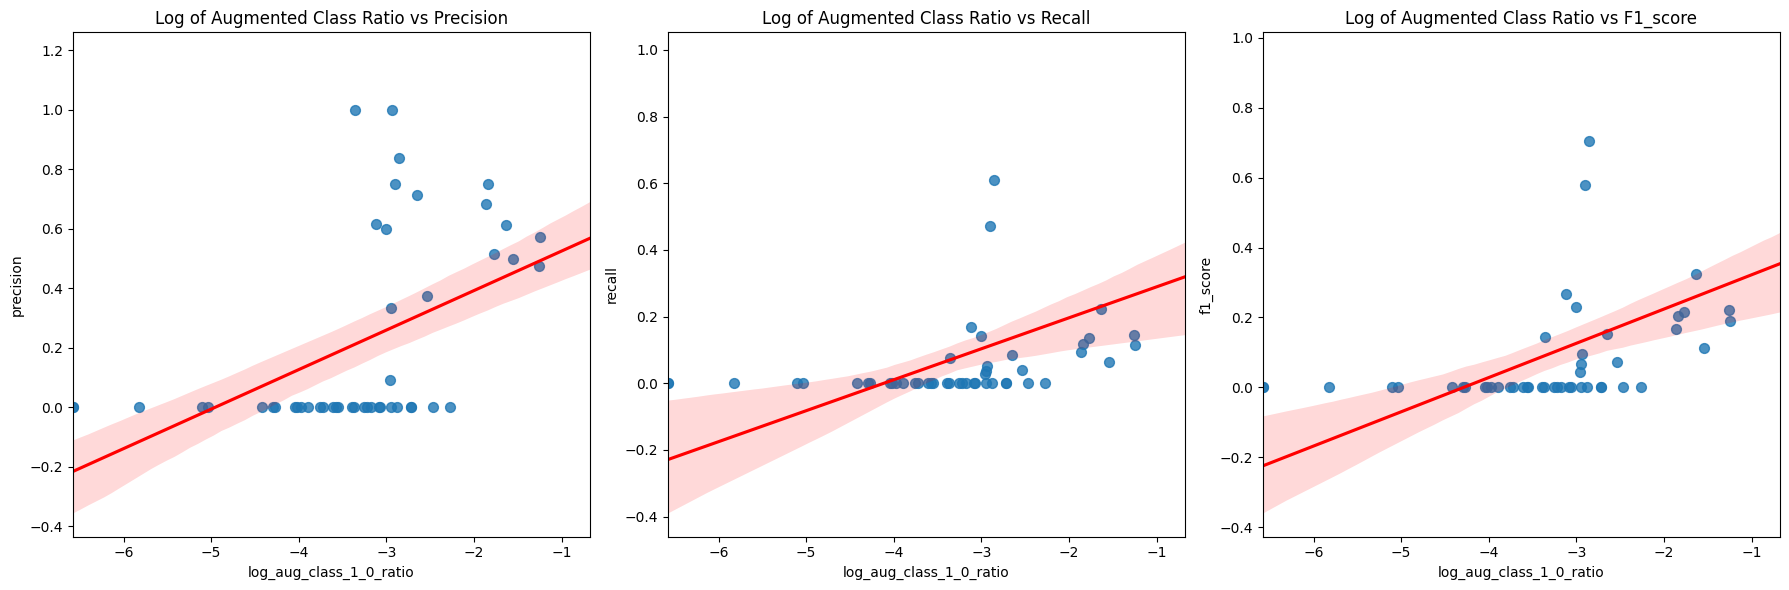

In [208]:
# Correlation of performance vs class ratio
metrics_df['log_aug_class_1_0_ratio'] = np.log(metrics_df['aug_class_1_0_ratio'] + 0.001)

plt.figure(figsize=(18, 6))

# Define axis limits
x_axis_limit = [metrics_df['log_aug_class_1_0_ratio'].min(), metrics_df['log_aug_class_1_0_ratio'].quantile(0.95)]

# Create scatter plots with log-transformed ratio and a linear fit line
for i, metric in enumerate(['precision', 'recall', 'f1_score'], 1):
    plt.subplot(1, 3, i)
    sns.regplot(
        data=metrics_df,
        x='log_aug_class_1_0_ratio',
        y=metric,
        scatter_kws={'s': 50},
        line_kws={'color': 'red'}
    )
    plt.xlim(x_axis_limit)  # Apply the limit to x-axis
    plt.title(f'Log of Augmented Class Ratio vs {metric.capitalize()}')

plt.tight_layout()
plt.show()

# generally positive correlation between the log-transformed class ratio and each of the precision, recall, and F1 score metrics

### Model 2b SMOTE + applying threshold ratio > 0.05

In [248]:
# Define threshold for excluding skills
threshold_ratio = 0.05
included_labels = []

for label in data.columns:
    if label.startswith('skill_k50_'):
        counts = data[label].value_counts()
        ratio = counts.get(1, 0) / (counts.get(0, 0) + 1e-6)  # Avoid division by zero
        if ratio >= threshold_ratio:
            included_labels.append(label)

# Filter the targets to include only those above the threshold ratio
y_train_threshold = data[included_labels]

In [249]:
y_train_threshold

,skill_k50_accounting / financial reporting / auditing,skill_k50_analysis / financial analysis / finance,skill_k50_banking / insurance / credit,skill_k50_biotechnology / life sciences / chemistry,skill_k50_business analysis / change management / integration,skill_k50_data analysis / databases / data warehousing,skill_k50_energy / environmental awareness / renewable energy,skill_k50_java / c++ / c,skill_k50_management / microsoft office / customer service,skill_k50_marketing / marketing strategy / social media marketing,skill_k50_problem solving / communication / organization,skill_k50_process improvement / manufacturing / cross-functional team leadership,skill_k50_project management / project planning / budgets,skill_k50_public relations / editing / digital media,skill_k50_public speaking / research / teaching,skill_k50_retail / forecasting / merchandising,skill_k50_social media / social networking / facebook,skill_k50_sql / linux / software development,skill_k50_strategic planning / team leadership / sales
0,1,1,0,1,0,1,0,0,1,1,0,1,0,0,0,0,0,0,1
1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,1,0,0,1
3,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
4,1,1,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3383,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3384,1,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3385,0,1,0,0,0,1,0,0,1,1,0,1,1,0,1,1,0,0,1
3386,0,1,0,0,0,1,0,1,1,0,1,0,0,0,1,0,1,0,1


In [250]:
# Apply threshold and filter the labels
included_labels = [label for label in data.columns if label.startswith('skill_k50_') and
                   data[label].value_counts(normalize=True).get(1, 0) >= threshold_ratio]

# Make sure you are filtering y from the same data structure or ensuring it aligns perfectly with X_train_augmented
if 'index' in X_train_augmented.columns:
    y_train_threshold = data.set_index('index')[included_labels].reindex(X_train_augmented.index)
else:
    y_train_threshold = data[included_labels].iloc[X_train_augmented.index]

# Confirm shapes
print(f"Shape of X_train_augmented: {X_train_augmented.shape}")
print(f"Shape of y_train_threshold: {y_train_threshold.shape}")

X_train, X_test, y_train, y_test = train_test_split(X_train_augmented, y_train_threshold, test_size=0.3, random_state=42)

Shape of X_train_augmented: (2571, 1453)
Shape of y_train_threshold: (2571, 18)


In [251]:
# Recalculate sample weights for the augmented dataset
sample_weights_augmented = np.array([
    compute_sample_weight(class_weight='balanced', y=y_train_threshold[col])
    for col in y_train_threshold.columns
])
sample_weights_augmented = np.mean(sample_weights_augmented, axis=0)

# Wrap the StackingClassifier with MultiOutputClassifier for multi-label classification
multi_label_sc_threshold = MultiOutputClassifier(stacking_classifier_base, n_jobs=-1)

# Fit the model on the augmented training data
multi_label_sc_threshold.fit(X_train_augmented, y_train_threshold, sample_weight=sample_weights_augmented)

MultiOutputClassifier(estimator=StackingClassifier(estimators=[('rf',
                                                                RandomForestClassifier(random_state=42)),
                                                               ('xgb',
                                                                XGBClassifier(base_score=None,
                                                                              booster=None,
                                                                              callbacks=None,
                                                                              colsample_bylevel=None,
                                                                              colsample_bynode=None,
                                                                              colsample_bytree=None,
                                                                              device=None,
                                                                              early_stopping_rounds=None,
                                                                              enable_categorical=False,
                                                                              eval_metric='mlogloss',
                                                                              feature_types=None,
                                                                              ga...
                                                                              learning_rate=None,
                                                                              max_bin=None,
                                                                              max_cat_threshold=None,
                                                                              max_cat_to_onehot=None,
                                                                              max_delta_step=None,
                                                                              max_depth=None,
                                                                              max_leaves=None,
                                                                              min_child_weight=None,
                                                                              missing=nan,
                                                                              monotone_constraints=None,
                                                                              multi_strategy=None,
                                                                              n_estimators=None,
                                                                              n_jobs=None,
                                                                              num_parallel_tree=None,
                                                                              random_state=None, ...))],
                                                   final_estimator=LogisticRegression(),
                                                   stack_method='predict'),
                      n_jobs=-1)

In [252]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, classification_report

# Predict on the test set
y_pred = multi_label_sc_threshold.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Recall: {recall_score(y_test, y_pred, average='samples')}")
print(f"Precision: {precision_score(y_test, y_pred, average='samples')}")
print(f"F1 Score: {f1_score(y_test, y_pred, average='samples')}")

Accuracy: 0.05699481865284974
Recall: 0.68405469386687
Precision: 0.7058506044905009
F1 Score: 0.641464803187601


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [253]:
print(classification_report(y_test, y_pred, target_names=y_train_threshold.columns))

                                                                                  precision    recall  f1-score   support

                           skill_k50_accounting / financial reporting / auditing       0.00      0.00      0.00       100
                               skill_k50_analysis / financial analysis / finance       0.90      1.00      0.95       693
                                          skill_k50_banking / insurance / credit       0.00      0.00      0.00       129
                             skill_k50_biotechnology / life sciences / chemistry       0.00      0.00      0.00        46
                   skill_k50_business analysis / change management / integration       0.00      0.00      0.00        90
                          skill_k50_data analysis / databases / data warehousing       0.00      0.00      0.00       114
                                                        skill_k50_java / c++ / c       0.00      0.00      0.00        48
                      s

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [255]:
def log_model_performance(model_performance_log, model_name, y_test, y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred, average='samples')
    precision = precision_score(y_test, y_pred, average='samples')
    f1 = f1_score(y_test, y_pred, average='samples')
    new_row = pd.DataFrame({
        'model': [model_name],
        'accuracy': [accuracy],
        'recall': [recall],
        'precision': [precision],
        'f1_score': [f1]
    })

    return pd.concat([model_performance_log, new_row], ignore_index=True)

model_performance_log = log_model_performance(model_performance_log, 'threshold + embedded summary + educ + exp + num_features + combined_text (SMOTE + SC)', y_test, y_pred)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Model 2b SMOTE + select only relevant skills

In [238]:
# List of relevant skills for equity research analysts
selected_labels = [
    'skill_k50_accounting / financial reporting / auditing',
    'skill_k50_analysis / financial analysis / finance',
    'skill_k50_banking / insurance / credit',
    'skill_k50_data analysis / databases / data warehousing',
    'skill_k50_management / microsoft office / customer service',
    'skill_k50_project management / project planning / budgets',
    'skill_k50_strategic planning / team leadership / sales',
    'skill_k50_sql / linux / software development'
]

# Filter the targets to include only selected skills
y_train_selected = data[selected_labels]

In [239]:
y_train_selected

,skill_k50_accounting / financial reporting / auditing,skill_k50_analysis / financial analysis / finance,skill_k50_banking / insurance / credit,skill_k50_data analysis / databases / data warehousing,skill_k50_management / microsoft office / customer service,skill_k50_project management / project planning / budgets,skill_k50_strategic planning / team leadership / sales,skill_k50_sql / linux / software development
0,1,1,0,1,1,0,1,0
1,0,1,0,0,0,0,0,0
2,0,0,0,0,1,0,1,0
3,0,1,1,0,0,0,1,0
4,1,1,1,0,1,0,1,0
...,...,...,...,...,...,...,...,...
3383,0,1,0,0,0,0,0,0
3384,1,1,1,0,1,0,0,0
3385,0,1,0,1,1,1,1,0
3386,0,1,0,1,1,0,1,0


In [240]:
# Make sure you are filtering y from the same data structure or ensuring it aligns perfectly with X_train_augmented
if 'index' in X_train_augmented.columns:
    y_train_selected = data.set_index('index')[selected_labels].reindex(X_train_augmented.index)
else:
    y_train_selected = data[selected_labels].iloc[X_train_augmented.index]

# Confirm shapes
print(f"Shape of X_train_augmented: {X_train_augmented.shape}")
print(f"Shape of y_train_selected: {y_train_selected.shape}")

X_train, X_test, y_train, y_test = train_test_split(X_train_augmented, y_train_selected, test_size=0.3, random_state=42)

Shape of X_train_augmented: (2571, 1453)
Shape of y_train_selected: (2571, 8)


In [241]:
# Define the base estimators
estimators = [
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'))
]

# Define the final estimator
final_estimator = LogisticRegression()

# Initialize StackingClassifier with `predict` as the stacking method
stacking_classifier_base = StackingClassifier(
    estimators=estimators,
    final_estimator=final_estimator,
    stack_method='predict'  # Enforce using predict to avoid shape mismatch
)

# Recalculate sample weights for the augmented dataset
sample_weights_augmented = np.array([
    compute_sample_weight(class_weight='balanced', y=y_train_selected[col])
    for col in y_train_selected.columns
])
sample_weights_augmented = np.mean(sample_weights_augmented, axis=0)

# Wrap the StackingClassifier with MultiOutputClassifier for multi-label classification
multi_label_sc_selected = MultiOutputClassifier(stacking_classifier_base, n_jobs=-1)

# Fit the model on the augmented training data
multi_label_sc_selected.fit(X_train_augmented, y_train_selected, sample_weight=sample_weights_augmented)

MultiOutputClassifier(estimator=StackingClassifier(estimators=[('rf',
                                                                RandomForestClassifier(random_state=42)),
                                                               ('xgb',
                                                                XGBClassifier(base_score=None,
                                                                              booster=None,
                                                                              callbacks=None,
                                                                              colsample_bylevel=None,
                                                                              colsample_bynode=None,
                                                                              colsample_bytree=None,
                                                                              device=None,
                                                                              early_stopping_rounds=None,
                                                                              enable_categorical=False,
                                                                              eval_metric='mlogloss',
                                                                              feature_types=None,
                                                                              ga...
                                                                              learning_rate=None,
                                                                              max_bin=None,
                                                                              max_cat_threshold=None,
                                                                              max_cat_to_onehot=None,
                                                                              max_delta_step=None,
                                                                              max_depth=None,
                                                                              max_leaves=None,
                                                                              min_child_weight=None,
                                                                              missing=nan,
                                                                              monotone_constraints=None,
                                                                              multi_strategy=None,
                                                                              n_estimators=None,
                                                                              n_jobs=None,
                                                                              num_parallel_tree=None,
                                                                              random_state=None, ...))],
                                                   final_estimator=LogisticRegression(),
                                                   stack_method='predict'),
                      n_jobs=-1)

In [242]:
# Predict on the test set
y_pred = multi_label_sc_selected.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Recall: {recall_score(y_test, y_pred, average='samples')}")
print(f"Precision: {precision_score(y_test, y_pred, average='samples')}")
print(f"F1 Score: {f1_score(y_test, y_pred, average='samples')}")

Accuracy: 0.05310880829015544
Recall: 0.6609610165309648
Precision: 0.667098445595855
F1 Score: 0.6105826959453903


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [243]:
print(classification_report(y_test, y_pred, target_names=y_train_selected.columns))

                                                            precision    recall  f1-score   support

     skill_k50_accounting / financial reporting / auditing       0.00      0.00      0.00       100
         skill_k50_analysis / financial analysis / finance       0.90      1.00      0.95       693
                    skill_k50_banking / insurance / credit       0.00      0.00      0.00       129
    skill_k50_data analysis / databases / data warehousing       0.00      0.00      0.00       114
skill_k50_management / microsoft office / customer service       0.44      1.00      0.61       337
 skill_k50_project management / project planning / budgets       0.00      0.00      0.00       105
    skill_k50_strategic planning / team leadership / sales       0.00      0.00      0.00       320
              skill_k50_sql / linux / software development       0.00      0.00      0.00        41

                                                 micro avg       0.67      0.56      0.61      183

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [244]:
def log_model_performance(model_performance_log, model_name, y_test, y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred, average='samples')
    precision = precision_score(y_test, y_pred, average='samples')
    f1 = f1_score(y_test, y_pred, average='samples')
    new_row = pd.DataFrame({
        'model': [model_name],
        'accuracy': [accuracy],
        'recall': [recall],
        'precision': [precision],
        'f1_score': [f1]
    })

    return pd.concat([model_performance_log, new_row], ignore_index=True)

model_performance_log = log_model_performance(model_performance_log, 'selected skills + embedded summary + educ + exp + num_features + combined_text (SMOTE + SC)', y_test, y_pred)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Summary

In [256]:
pd.set_option('display.max_colwidth', None)
model_performance_log.sort_values(by='f1_score', ascending=False)

,model,accuracy,recall,precision,f1_score
6,threshold + embedded summary + educ + exp + num_features + combined_text (SMOTE + SC),0.056995,0.684055,0.705851,0.641465
5,selected skills + embedded summary + educ + exp + num_features + combined_text (SMOTE + SC),0.053109,0.660961,0.667098,0.610583
4,embedded summary + educ + exp + num_features + combined_text (SMOTE + SC),0.132743,0.543100,0.789746,0.575614
1,combined_text with num_features,0.188791,0.490276,0.868289,0.567076
0,combined_text only,0.183874,0.484431,0.869354,0.562737
2,embedded summary + educ + exp + num_features + combined_text,0.193707,0.467085,0.876926,0.550281
3,embedded summary + educ + exp + num_features + combined_text (SMOTE),0.173058,0.474504,0.852671,0.548628


Remarks:
*   Recall = correctly captures the positive class - often lower due to the class imbalance
*   Precision = correctly predicts a skill
*   F1 Score = balances the above two
*   Accuracy = can be misleading if the class distribution is imbalanced (if only a few people have the rare skills/ imbalance class)

Class imbalance leads the model to be more conservative in predicting the minority class (positive cases for rare skills), leading to fewer false positives (hence higher precision) but also fewer true positives among the actual positive cases (hence lower recall).